10.1103/PhysRevLett.96.086601

In [38]:
import os

for env in ["MKL_NUM_THREADS", "NUMEXPR_NUM_THREADS", "OMP_NUM_THREADS"]:
    os.environ[env] = "1"
    del env

import numpy as np
import scipy.sparse
import tqdm
from matplotlib import pyplot as plt

In [53]:
cm_inv_convertor = 4.5563e-6  # a.u. / cm-1
amu_convertor = 1823  # a.u. / amu
A_convertor = 1.88973 # a.u. / A
ps_convertor = 41341 # a.u. / ps
K_convertor = 1.38064881e-23 / 4.3597447222071e-18


m = 250 * amu_convertor
K = 14500 * amu_convertor / ps_convertor ** 2
# N = 600 in the paper
N = 100
tau = 300 * cm_inv_convertor
alpha = 995 * cm_inv_convertor / A_convertor
dt = 0.025e-3 * ps_convertor
T = 300 * K_convertor

In [31]:
trajectories = []

# 125 trajctories in the paper
for trajectory_idx in range(1):
    u = np.random.normal(0, np.sqrt(T/K), N)
    v = np.random.normal(0, np.sqrt(T/m), N)


    def periodic_diag(d):
        H = scipy.sparse.diags(d[:-1], offsets=1) + scipy.sparse.diags(d[:-1], offsets=-1) \
         + scipy.sparse.diags([d[-1]], offsets=len(d)-1) + scipy.sparse.diags([d[-1]], offsets=1-len(d))
        return H


    diag_elems = -tau + alpha * (np.roll(u, -1) - u)
    H = periodic_diag(diag_elems)


    evals, evecs = np.linalg.eigh(H.toarray())
    prop = np.exp(-evals/T)
    prop /= prop.sum()
    init_idx = np.random.choice(np.arange(N), p=prop)
    C = evecs[:, init_idx].reshape(N)

    C_p1 = np.roll(C, -1)
    C_m1 = np.roll(C, 1)

    a = ( -K * u - alpha * (-C.conj() * C_p1 - C_p1.conj() * C + C_m1.conj() * C + C.conj() * C_m1) ) / m

    new_u = u + v * dt + 1/2 * a * dt**2

    deriv_diag_elems = alpha * (np.roll(v, -1) - v)
    H_deriv = periodic_diag(deriv_diag_elems)
    new_C = C - 1j * H * dt @ C - 1/2 * 1j * ( H @ (-1j * H @ C) + H_deriv @ C) * dt**2

    stored_C = [C]

    # 600e3 steps in the paper
    for i in tqdm.tqdm(range(1, int(100e3))):
        old_u, old_C = u, C
        u, C = new_u, new_C
        C_p1 = np.roll(C, -1)
        C_m1 = np.roll(C, 1)
        v = (u - old_u) / dt
        a = (-K * u - alpha * (-C.conj() * C_p1 - C_p1.conj() * C + C_m1.conj() * C + C.conj() * C_m1)) / m
        new_u = 2 * u - old_u + a * dt ** 2

        diag_elems = -tau + alpha * (np.roll(u, -1) - u)
        H = periodic_diag(diag_elems)
        deriv_diag_elems = alpha * (np.roll(v, -1) - v)
        H_deriv = periodic_diag(deriv_diag_elems)
        HC = H @ C
        new_C = C - 1j * HC * dt - 1 / 2 * 1j * (H @ (-1j * HC) + H_deriv @ C) * dt ** 2

        if i % 1000 == 999:
            stored_C.append(C)

    trajectories.append(stored_C)


100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [07:33<00:00, 220.66it/s]


In [34]:
occus = [(np.array(stored_C).conj() * stored_C) for stored_C in trajectories]

In [46]:
occu = occus[0]
occu = np.roll(occu, N//2 - occu[0].argmax())

In [51]:
r2 = np.arange(N) ** 2 @ occu.T - (np.arange(N) @ occu.T) **2

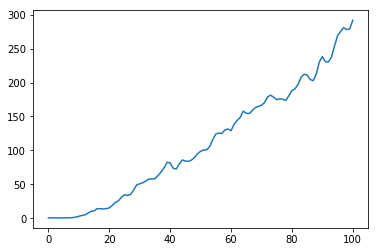

In [54]:
plt.plot(r2)